## Code_Changes_Git
This is the reference implementation for [Code_Changes](https://github.com/chaoss/wg-evolution/blob/master/metrics/Code_Changes.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Code_Changes
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Examples of how to check for specific peculiarities of git commits

As discussed in the [README](README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from code_df import utils
from code_df.is_source_code import IsSourceCode, Naive
from code_df.commit import Commit
%matplotlib inline

In [2]:
class CodeChangesGit(Commit):
    """Class for Code_Changes for Git repositories.

    :param items: A list of dictionaries, each element a line from the
        JSON file with Perceval data
    :param date_range: A tuple which represents the start and end date of
        interest
    :param issrccode_obj: An object of IsSourceCode, used to determine
        what comprises source code.
    """

    def __init__(self, items, date_range=(None, None), issrccode_obj=None):

        super().__init__(items, date_range, issrccode_obj)

    def compute(self, incl_empty=True, incl_merge=True, master_only=False):
        """Count number of commits of different types, like including empty commits
        or counting only those commits made on the master branch.

        :param incl_empty: Include empty commits
        :param incl_merge: Include merge commits
        :param master_only: Include only commits made on master branch

        :returns count: the number of commits satisfying the passed
            conditions above
        """
        df = self.df

        if master_only:
            count = self._count_master_only(incl_empty)

        else:
            if not incl_empty:
                df = df[df['files_action'] != 0]
            if not incl_merge:
                df = df[~df['merge']]
            count = df['hash'].nunique()

        return count

    def compute_timeseries(self, period='month'):
        """
        The metric value is computed for each fixed interval of time
        from the "since" date to the "until" date arguments, specified
        during object initiation.

        The fixed time interval can be either a month or a week.

        :param period: A string which can be either "month" or "week"

        :returns dataframe: A DataFrame whose rows each represent an interval
            of "period" and the count for that interval
        """

        df = self.df
        if period == 'month':
            timeseries_series = df['created_date'] \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.month.rename('month')]) \
                .agg('count')

            all_periods = pd.DataFrame(
                            pd.date_range(self.since, self.until, freq='M'),
                            columns=['Dates'])
            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename('year'),
                 all_periods['Dates'].dt.month.rename("month")]).T

        elif period == 'week':
            timeseries_series = df['created_date'] \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.week.rename('week')])   \
                .agg('count')

            all_periods = pd.DataFrame(
                            pd.date_range(self.since, self.until, freq='W'),
                            columns=['Dates'])
            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename('year'),
                 all_periods['Dates'].dt.week.rename('week')]).T

        else:
            raise ValueError("period parameter can take 'month' or 'week'")

        timeseries_df = pd.DataFrame(timeseries_series)
        timeseries_df.reset_index(inplace=True)
        timeseries_df.columns = ['year', period, 'count']
        merged_df = all_periods.merge(timeseries_df, how='outer').fillna(0)

        dataframe = merged_df
        return dataframe

    def _count_master_only(self, incl_empty=True):
        """
        Counts commits present only on the master branch.

        :param incl_empty: exclude empty commits on the master branch

        :returns commits_count: the number of commits created on the
            master branch
        """

        df = self.df
        todo = set()
        for _, commit in df.iterrows():
            if 'HEAD -> refs/heads/master' in commit['refs']:
                todo.add(commit['hash'])

        master = set()
        while len(todo) > 0:
            current = todo.pop()
            master.add(current)

            if len(df[df['hash'] == current]['parents']) > 0:
                for parent in df[df['hash'] == current]['parents'].iloc[0]:
                    if parent not in master:
                        todo.add(parent)

        if not incl_empty:
            commits_count = 0
            for commit_id in master:
                commit = df[df['hash'] == commit_id]
                if len(commit['files']) > 0:
                    for file in commit['files'].iloc[0]:
                        if 'action' in file:
                            commits_count += 1
                            break

        else:
            commits_count = len(master)

        return commits_count

## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 
For starters, we can perform a simple count of all commits in the file. To make things simple, we can use a naive implementation for deciding whether a given commit affects the source code or not. Again, the naive implementation assumes that all files are part of the source code, and hence, all commits are considered to affect it. 

### Counting the total number of commits 
We first create a IsSourceCode object with a naive implementation, and then pass that along with the data of the JSON file as a list to Code_Changes_Git.

In [3]:
sourcecode = IsSourceCode(algorithm_class=Naive)
items = utils.read_JSON_file('../git-commits.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be %Y-%m-%d.

In [4]:
changes = CodeChangesGit(items, issrccode_obj=sourcecode)
print("The total number of commits in the file is: {}".format(changes.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")

changes_interval = CodeChangesGit(items, (date_since, date_until), issrccode_obj=sourcecode)
print("The total number of commits between 2018-01-01 and 2018-07-01 in the file is: {}".format(changes_interval.compute()))

The total number of commits in the file is: 1963
The total number of commits between 2018-01-01 and 2018-07-01 in the file is: 437


### Counting the total number of commits excluding merge commits
Moving on, lets make use of the `empty` and `merge` parameters of `compute()`. To reiterate, passing `empty` or `merge` as `True`, which is the default behaviour includes empty and merge commits in the count. Of course, to exclude them, we would just have to pass `False`. Below, let's calculate the number of non-merge commits. 

In [5]:
print("The total number of non-merge commits between 2018-01-01 and 2018-07-01 are: {}".format(changes_interval.compute(incl_empty=False)))

The total number of non-merge commits between 2018-01-01 and 2018-07-01 are: 317


## Counting commits over regular time intervals
Using the `compute_timeseries` method, it is possible to compute the number of commits created every month, or every week. This kind of analysis is useful in finding trends over time, as we will see in the cell below. Let's perform a basic analysis: lets see the change in the number of commits created between the same dates we used above on a weekly basis: 2018-01-01 and 2018-07-01. The Code_Changes_Git object will be the same as used above.

In [6]:
weekly_df = changes_interval.compute_timeseries("week")

Lets see what the dataframe returned by `compute_timeseries` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. A simple merge between the dataframes of all possible weeks and the commit count dataframe (which would of course, be missing several rows(weeks) where there would be no commits) gave us this output. 

In [7]:
weekly_df

,year,week,count
0,2018,1,4
1,2018,2,11
2,2018,3,31
3,2018,4,44
4,2018,5,20
5,2018,6,9
6,2018,7,27
7,2018,8,14
8,2018,9,77
9,2018,10,74


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- commit count vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plot and the x axis.

Text(0.5, 1.0, 'Commit Timeseries')

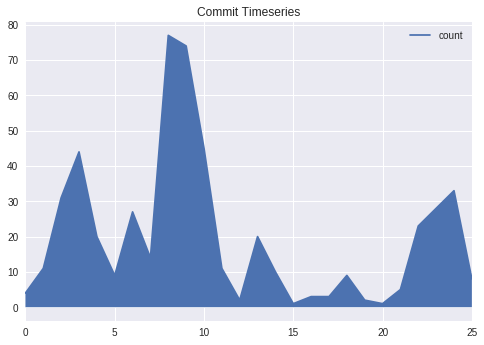

In [8]:
plt.style.use('seaborn')
weekly_df.plot(y='count', use_index=True)
plt.fill_between(y1=weekly_df['count'], y2=0, x=weekly_df.index)
plt.title("Commit Timeseries")

The same thing can be tried for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale. 

## Counting commits only made on the master branch
Another option one has while using this class for analyzing git commit data is to include only those commits for analysis which are on the master branch. To do this, simply pass `True` for the `master_only` attribute of the compute function.

In [9]:
print("The total number of commits made on the master branch is: {}".format(changes.compute(master_only=True)))

The total number of commits made on the master branch is: 1913


Lets do one last thing: the same thing we did in the cell above, but without including empty commits: 

In [10]:
print("The total number of non-empty commits made on the master branch is: {}".format(changes.compute(incl_empty=False, master_only=True)))

The total number of non-empty commits made on the master branch is: 1572
